# Comparison of scenarios

1. re

In [1]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle
import os

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
when = 'future'
file_prefix = f'week'
outdir = '2021-01-19-107_90/'

n_int_steps = 6
nnodes = 107  # nodes
ndays_ocp = 90
ndays = 180

setup = ItalySetup(nnodes, ndays, when)
setup_ocp = ItalySetup(nnodes, ndays_ocp, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'italy-data/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)
    
os.makedirs('model_output/scenarios', exist_ok=True)

scenarios = {pick_scenario(setup, i)['name']:pick_scenario(setup, i) for i in np.arange(30)}
scenarios.keys()

Loaded Italy Setup with 107 nodes.
Loaded Italy Setup with 107 nodes.


dict_keys(['U-r1-t125000-id0', 'L-r1-t125000-id1', 'U-r2-t125000-id2', 'L-r2-t125000-id3', 'U-r15-t125000-id4', 'L-r15-t125000-id5', 'U-r1-t250000-id6', 'L-r1-t250000-id7', 'U-r2-t250000-id8', 'L-r2-t250000-id9', 'U-r15-t250000-id10', 'L-r15-t250000-id11', 'U-r1-t479700-id12', 'L-r1-t479700-id13', 'U-r2-t479700-id14', 'L-r2-t479700-id15', 'U-r15-t479700-id16', 'L-r15-t479700-id17', 'U-r1-t1000000-id18', 'L-r1-t1000000-id19', 'U-r2-t1000000-id20', 'L-r2-t1000000-id21', 'U-r15-t1000000-id22', 'L-r15-t1000000-id23', 'U-r1-t2000000-id24', 'L-r1-t2000000-id25', 'U-r2-t2000000-id26', 'L-r2-t2000000-id27', 'U-r15-t2000000-id28', 'L-r15-t2000000-id29'])

In [ ]:
# Choose a subset of scenarios:
pick = 'L-r15'
scenarios = {k:v for (k,v) in scenarios.items() if pick in k}
print(len(scenarios))

In [ ]:
scenarios.keys()

In [3]:
scenarios_opt = {}
scenarios_baseline = {}
## Re-integrate vacc
for scenario_name, scenario in scenarios.items():
    fname = f"{outdir}{file_prefix}-{'-'.join(scenario_name.split('-')[:-1])}-opt-{nnodes}_{ndays_ocp}.csv"
    try:
        md = pd.read_csv(fname, index_col= 'date', parse_dates=True)
        print(f'YES {fname}')
    
        # Build scenario
        maxvaccrate_regional, delivery_national, stockpile_national_constraint, control_initial = build_scenario(setup, scenario)
        M = setup.nnodes
        N = setup.ndays - 1
        control_initial = np.zeros((M, N))
        unvac_nd = np.copy(setup.pop_node)
        stockpile = 0
        for k in range(ndays_ocp - 1):
            stockpile += delivery_national[k]
            for nodename in md.place.unique():
                nd = setup.ind2name.index(nodename)
                to_allocate = md[(md['place'] == nodename) & (md['comp'] == 'vacc')].iloc[k]['value']
                to_allocate = min(to_allocate, maxvaccrate_regional[nd, k], unvac_nd[nd], stockpile)
                control_initial[nd, k] = to_allocate
                stockpile -= to_allocate
                unvac_nd[nd] -= to_allocate
        p.apply_epicourse(setup, scenario['beta_mult'])
        # END Build scenario

        results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                          setup=setup,
                                                                          parameters=p,
                                                                          controls=control_initial,
                                                                          save_to=f'model_output/scenarios/{scenario_name}-opi-{nnodes}_{ndays}',
                                                                          n_rk4_steps=n_int_steps)
        results.set_index('date', drop=True, inplace=True)
        scenarios_opt[scenario_name] = scenario
        print(f'--> DONE {scenario_name}')

        if scenario_name.split('-')[0] not in scenarios_baseline:
            control_initial = np.zeros((M, N))
            # Generate NO vaccination scenarios
            results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'model_output/scenarios/{scenario_name}-novacc-{nnodes}_{ndays}',
                                                                      n_rk4_steps=n_int_steps)
            scenarios_baseline[scenario_name.split('-')[0]] = pd.read_csv(f'model_output/scenarios/{scenario_name}-novacc-{nnodes}_{ndays}.csv', 
                                                                         index_col= 'date', parse_dates=True)


    except FileNotFoundError:
        print(f'NOT {fname}')

YES 2021-01-19-107_90/week-U-r1-t125000-opt-107_90.csv


  2%|▏         | 3/179 [00:00<00:08, 20.86it/s]

===> Integrating for model_output/scenarios/U-r1-t125000-id0-opi-107_180


  3%|▎         | 5/179 [00:00<00:09, 19.30it/s]

--> DONE U-r1-t125000-id0
===> Integrating for model_output/scenarios/U-r1-t125000-id0-novacc-107_180


100%|██████████| 179/179 [00:09<00:00, 19.68it/s]


YES 2021-01-19-107_90/week-L-r1-t125000-opt-107_90.csv


  2%|▏         | 3/179 [00:00<00:07, 22.10it/s]

===> Integrating for model_output/scenarios/L-r1-t125000-id1-opi-107_180


  2%|▏         | 3/179 [00:00<00:07, 22.09it/s]

--> DONE L-r1-t125000-id1
===> Integrating for model_output/scenarios/L-r1-t125000-id1-novacc-107_180


100%|██████████| 179/179 [00:08<00:00, 20.87it/s]


YES 2021-01-19-107_90/week-U-r2-t125000-opt-107_90.csv


  2%|▏         | 3/179 [00:00<00:08, 20.35it/s]

===> Integrating for model_output/scenarios/U-r2-t125000-id2-opi-107_180


100%|██████████| 179/179 [00:08<00:00, 20.28it/s]


--> DONE U-r2-t125000-id2
YES 2021-01-19-107_90/week-L-r2-t125000-opt-107_90.csv


  1%|          | 2/179 [00:00<00:11, 15.54it/s]

===> Integrating for model_output/scenarios/L-r2-t125000-id3-opi-107_180


100%|██████████| 179/179 [00:09<00:00, 18.96it/s]


--> DONE L-r2-t125000-id3
YES 2021-01-19-107_90/week-U-r15-t125000-opt-107_90.csv


  2%|▏         | 3/179 [00:00<00:08, 20.15it/s]

===> Integrating for model_output/scenarios/U-r15-t125000-id4-opi-107_180


100%|██████████| 179/179 [00:08<00:00, 20.80it/s]


--> DONE U-r15-t125000-id4
YES 2021-01-19-107_90/week-L-r15-t125000-opt-107_90.csv


  2%|▏         | 3/179 [00:00<00:08, 21.19it/s]

===> Integrating for model_output/scenarios/L-r15-t125000-id5-opi-107_180


100%|██████████| 179/179 [00:08<00:00, 20.41it/s]


--> DONE L-r15-t125000-id5
YES 2021-01-19-107_90/week-U-r1-t250000-opt-107_90.csv


  1%|          | 2/179 [00:00<00:09, 19.15it/s]

===> Integrating for model_output/scenarios/U-r1-t250000-id6-opi-107_180


100%|██████████| 179/179 [00:09<00:00, 18.05it/s]


--> DONE U-r1-t250000-id6
YES 2021-01-19-107_90/week-L-r1-t250000-opt-107_90.csv


  1%|          | 2/179 [00:00<00:09, 19.54it/s]

===> Integrating for model_output/scenarios/L-r1-t250000-id7-opi-107_180


100%|██████████| 179/179 [00:08<00:00, 20.51it/s]


--> DONE L-r1-t250000-id7
YES 2021-01-19-107_90/week-U-r2-t250000-opt-107_90.csv


  2%|▏         | 3/179 [00:00<00:08, 20.88it/s]

===> Integrating for model_output/scenarios/U-r2-t250000-id8-opi-107_180


100%|██████████| 179/179 [00:08<00:00, 20.24it/s]


--> DONE U-r2-t250000-id8
YES 2021-01-19-107_90/week-L-r2-t250000-opt-107_90.csv


  1%|          | 2/179 [00:00<00:09, 19.55it/s]

===> Integrating for model_output/scenarios/L-r2-t250000-id9-opi-107_180


100%|██████████| 179/179 [00:09<00:00, 19.80it/s]


--> DONE L-r2-t250000-id9
YES 2021-01-19-107_90/week-U-r15-t250000-opt-107_90.csv


  2%|▏         | 3/179 [00:00<00:08, 20.37it/s]

===> Integrating for model_output/scenarios/U-r15-t250000-id10-opi-107_180


100%|██████████| 179/179 [00:09<00:00, 19.20it/s]


--> DONE U-r15-t250000-id10
YES 2021-01-19-107_90/week-L-r15-t250000-opt-107_90.csv


  1%|          | 2/179 [00:00<00:09, 18.74it/s]

===> Integrating for model_output/scenarios/L-r15-t250000-id11-opi-107_180


100%|██████████| 179/179 [00:08<00:00, 21.03it/s]


--> DONE L-r15-t250000-id11
YES 2021-01-19-107_90/week-U-r1-t479700-opt-107_90.csv


  3%|▎         | 5/179 [00:00<00:08, 20.13it/s]

===> Integrating for model_output/scenarios/U-r1-t479700-id12-opi-107_180


100%|██████████| 179/179 [00:08<00:00, 20.42it/s]


--> DONE U-r1-t479700-id12
YES 2021-01-19-107_90/week-L-r1-t479700-opt-107_90.csv


  1%|          | 2/179 [00:00<00:09, 19.54it/s]

===> Integrating for model_output/scenarios/L-r1-t479700-id13-opi-107_180


100%|██████████| 179/179 [00:09<00:00, 19.69it/s]


--> DONE L-r1-t479700-id13
YES 2021-01-19-107_90/week-U-r2-t479700-opt-107_90.csv


  1%|          | 2/179 [00:00<00:09, 19.50it/s]

===> Integrating for model_output/scenarios/U-r2-t479700-id14-opi-107_180


100%|██████████| 179/179 [00:09<00:00, 19.07it/s]


--> DONE U-r2-t479700-id14
YES 2021-01-19-107_90/week-L-r2-t479700-opt-107_90.csv


  1%|          | 2/179 [00:00<00:11, 15.26it/s]

===> Integrating for model_output/scenarios/L-r2-t479700-id15-opi-107_180


100%|██████████| 179/179 [00:09<00:00, 19.29it/s]


--> DONE L-r2-t479700-id15
YES 2021-01-19-107_90/week-U-r15-t479700-opt-107_90.csv


  2%|▏         | 3/179 [00:00<00:08, 20.51it/s]

===> Integrating for model_output/scenarios/U-r15-t479700-id16-opi-107_180


100%|██████████| 179/179 [00:09<00:00, 19.52it/s]


--> DONE U-r15-t479700-id16
YES 2021-01-19-107_90/week-L-r15-t479700-opt-107_90.csv


  1%|          | 2/179 [00:00<00:08, 19.69it/s]

===> Integrating for model_output/scenarios/L-r15-t479700-id17-opi-107_180


100%|██████████| 179/179 [00:09<00:00, 19.60it/s]


--> DONE L-r15-t479700-id17
YES 2021-01-19-107_90/week-U-r1-t1000000-opt-107_90.csv


  1%|          | 2/179 [00:00<00:09, 19.66it/s]

===> Integrating for model_output/scenarios/U-r1-t1000000-id18-opi-107_180


100%|██████████| 179/179 [00:08<00:00, 21.78it/s]


--> DONE U-r1-t1000000-id18
YES 2021-01-19-107_90/week-L-r1-t1000000-opt-107_90.csv


  3%|▎         | 5/179 [00:00<00:08, 21.04it/s]

===> Integrating for model_output/scenarios/L-r1-t1000000-id19-opi-107_180


100%|██████████| 179/179 [00:08<00:00, 21.76it/s]


--> DONE L-r1-t1000000-id19
YES 2021-01-19-107_90/week-U-r2-t1000000-opt-107_90.csv


  2%|▏         | 3/179 [00:00<00:08, 20.32it/s]

===> Integrating for model_output/scenarios/U-r2-t1000000-id20-opi-107_180


100%|██████████| 179/179 [00:08<00:00, 21.71it/s]


--> DONE U-r2-t1000000-id20
YES 2021-01-19-107_90/week-L-r2-t1000000-opt-107_90.csv


  2%|▏         | 3/179 [00:00<00:08, 20.48it/s]

===> Integrating for model_output/scenarios/L-r2-t1000000-id21-opi-107_180


100%|██████████| 179/179 [00:08<00:00, 21.20it/s]


--> DONE L-r2-t1000000-id21
NOT 2021-01-19-107_90/week-U-r15-t1000000-opt-107_90.csv
YES 2021-01-19-107_90/week-L-r15-t1000000-opt-107_90.csv


  2%|▏         | 3/179 [00:00<00:07, 22.27it/s]

===> Integrating for model_output/scenarios/L-r15-t1000000-id23-opi-107_180


100%|██████████| 179/179 [00:08<00:00, 22.15it/s]


--> DONE L-r15-t1000000-id23
YES 2021-01-19-107_90/week-U-r1-t2000000-opt-107_90.csv


  2%|▏         | 3/179 [00:00<00:07, 23.09it/s]

===> Integrating for model_output/scenarios/U-r1-t2000000-id24-opi-107_180


100%|██████████| 179/179 [00:08<00:00, 21.93it/s]


--> DONE U-r1-t2000000-id24
YES 2021-01-19-107_90/week-L-r1-t2000000-opt-107_90.csv


  3%|▎         | 6/179 [00:00<00:08, 21.21it/s]

===> Integrating for model_output/scenarios/L-r1-t2000000-id25-opi-107_180


100%|██████████| 179/179 [00:07<00:00, 22.54it/s]


--> DONE L-r1-t2000000-id25
YES 2021-01-19-107_90/week-U-r2-t2000000-opt-107_90.csv


  2%|▏         | 3/179 [00:00<00:07, 22.65it/s]

===> Integrating for model_output/scenarios/U-r2-t2000000-id26-opi-107_180


100%|██████████| 179/179 [00:07<00:00, 22.63it/s]


--> DONE U-r2-t2000000-id26
YES 2021-01-19-107_90/week-L-r2-t2000000-opt-107_90.csv


  2%|▏         | 3/179 [00:00<00:08, 20.22it/s]

===> Integrating for model_output/scenarios/L-r2-t2000000-id27-opi-107_180


100%|██████████| 179/179 [00:07<00:00, 22.48it/s]


--> DONE L-r2-t2000000-id27
NOT 2021-01-19-107_90/week-U-r15-t2000000-opt-107_90.csv
YES 2021-01-19-107_90/week-L-r15-t2000000-opt-107_90.csv


  2%|▏         | 3/179 [00:00<00:07, 23.01it/s]

===> Integrating for model_output/scenarios/L-r15-t2000000-id29-opi-107_180


100%|██████████| 179/179 [00:07<00:00, 22.51it/s]


--> DONE L-r15-t2000000-id29


In [4]:
# Generate alternatives:
# BY INCIDENCE: 
for scenario_name, scenario in scenarios_opt.items():
    nv = scenarios_baseline[scenario_name.split('-')[0]]
    incid = nv[nv['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R'])].groupby('placeID').sum()
    incid.sort_values('value', ascending=False)
    
    # Build scenario
    maxvaccrate_regional, delivery_national, stockpile_national_constraint, control_initial = build_scenario(setup, scenario)
    M = setup.nnodes
    N = setup.ndays - 1
    control_initial = np.zeros((M, N))
    unvac_nd = np.copy(setup.pop_node)
    stockpile = 0
    for k in range(ndays_ocp -1):
        stockpile += delivery_national[k]
        for nodename in md.place.unique():
            nd = setup.ind2name.index(nodename)
            to_allocate = stockpile * incid.loc[nd]['value'] / incid['value'].sum()
            to_allocate = min(to_allocate, maxvaccrate_regional[nd, k], unvac_nd[nd], stockpile)
            control_initial[nd, k] = to_allocate
            stockpile -= to_allocate
            unvac_nd[nd] -= to_allocate
    p.apply_epicourse(setup, scenario['beta_mult'])
    # END Build scenario

    results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'model_output/scenarios/{scenario_name}-inc-{nnodes}_{ndays}',
                                                                      n_rk4_steps=n_int_steps)
    results.set_index('date', drop=True, inplace=True)

# BY Suceptibility: 
for scenario_name, scenario in scenarios_opt.items():
    nv = scenarios_baseline[scenario_name.split('-')[0]]
    incid = nv[nv['comp'].isin(['S'])].loc[str(setup.start_date)]
    incid.set_index('placeID', inplace=True)
    
    # Build scenario
    maxvaccrate_regional, delivery_national, stockpile_national_constraint, control_initial = build_scenario(setup, scenario)
    M = setup.nnodes
    N = setup.ndays - 1
    control_initial = np.zeros((M, N))
    unvac_nd = np.copy(setup.pop_node)
    stockpile = 0
    for k in range(ndays_ocp -1):
        stockpile += delivery_national[k]
        for nodename in md.place.unique():
            nd = setup.ind2name.index(nodename)
            to_allocate = stockpile * incid.loc[nd]['value'] / incid['value'].sum()
            to_allocate = min(to_allocate, maxvaccrate_regional[nd, k], unvac_nd[nd], stockpile)
            control_initial[nd, k] = to_allocate
            stockpile -= to_allocate
            unvac_nd[nd] -= to_allocate
    p.apply_epicourse(setup, scenario['beta_mult'])
    # END Build scenario

    results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'model_output/scenarios/{scenario_name}-sus-{nnodes}_{ndays}',
                                                                      n_rk4_steps=n_int_steps)
    results.set_index('date', drop=True, inplace=True)
    

    
# BY POPULATION 
for scenario_name, scenario in scenarios_opt.items():
    # Build scenario
    maxvaccrate_regional, delivery_national, stockpile_national_constraint, control_initial = build_scenario(setup, scenario)
    M = setup.nnodes
    N = setup.ndays - 1
    control_initial = np.zeros((M, N))
    unvac_nd = np.copy(setup.pop_node)
    stockpile = 0
    for k in range(ndays_ocp -1):
        stockpile += delivery_national[k]
        for nodename in md.place.unique():
            pop_nd = setup.pop_node[nd]
            nd = setup.ind2name.index(nodename)
            to_allocate = stockpile * pop_nd / setup.pop_node.sum()
            to_allocate = min(to_allocate, maxvaccrate_regional[nd, k], unvac_nd[nd], stockpile)
            control_initial[nd, k] = to_allocate
            stockpile -= to_allocate
            unvac_nd[nd] -= to_allocate
    p.apply_epicourse(setup, scenario['beta_mult'])
    # END Build scenario

    results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'model_output/scenarios/{scenario_name}-pop-{nnodes}_{ndays}',
                                                                      n_rk4_steps=n_int_steps)
    results.set_index('date', drop=True, inplace=True)
    
# BY FUTURE NEW CASES
for scenario_name, scenario in scenarios_opt.items():
    nv = scenarios_baseline[scenario_name.split('-')[0]]
    incid = nv[nv['comp'].isin(['E', 'I', 'A'])].groupby('placeID').sum()
    incid.sort_values('value', ascending=False)
    
    # Build scenario
    maxvaccrate_regional, delivery_national, stockpile_national_constraint, control_initial = build_scenario(setup, scenario)
    M = setup.nnodes
    N = setup.ndays - 1
    control_initial = np.zeros((M, N))
    unvac_nd = np.copy(setup.pop_node)
    stockpile = 0
    for k in range(ndays_ocp - 1):
        stockpile += delivery_national[k]
        for nodename in md.place.unique():
            nd = setup.ind2name.index(nodename)
            to_allocate = stockpile * incid.loc[nd]['value'] / incid['value'].sum()
            to_allocate = min(to_allocate, maxvaccrate_regional[nd, k], unvac_nd[nd], stockpile)
            control_initial[nd, k] = to_allocate
            stockpile -= to_allocate
            unvac_nd[nd] -= to_allocate
    p.apply_epicourse(setup, scenario['beta_mult'])
    # END Build scenario

    results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'model_output/scenarios/{scenario_name}-cas-{nnodes}_{ndays}',
                                                                      n_rk4_steps=n_int_steps)
    results.set_index('date', drop=True, inplace=True)

#TODO: Centrality based and R0 based

  2%|▏         | 3/179 [00:00<00:07, 23.35it/s]

===> Integrating for model_output/scenarios/U-r1-t125000-id0-inc-107_180


  2%|▏         | 3/179 [00:00<00:08, 21.77it/s]

===> Integrating for model_output/scenarios/L-r1-t125000-id1-inc-107_180


  2%|▏         | 3/179 [00:00<00:07, 22.57it/s]

===> Integrating for model_output/scenarios/U-r2-t125000-id2-inc-107_180


  2%|▏         | 3/179 [00:00<00:08, 20.51it/s]

===> Integrating for model_output/scenarios/L-r2-t125000-id3-inc-107_180


  2%|▏         | 3/179 [00:00<00:08, 20.61it/s]

===> Integrating for model_output/scenarios/U-r15-t125000-id4-inc-107_180


  2%|▏         | 3/179 [00:00<00:08, 20.51it/s]

===> Integrating for model_output/scenarios/L-r15-t125000-id5-inc-107_180


  3%|▎         | 5/179 [00:00<00:08, 20.22it/s]

===> Integrating for model_output/scenarios/U-r1-t250000-id6-inc-107_180


  2%|▏         | 4/179 [00:00<00:09, 19.43it/s]

===> Integrating for model_output/scenarios/L-r1-t250000-id7-inc-107_180


  2%|▏         | 3/179 [00:00<00:08, 20.94it/s]

===> Integrating for model_output/scenarios/U-r2-t250000-id8-inc-107_180


  2%|▏         | 3/179 [00:00<00:08, 21.22it/s]

===> Integrating for model_output/scenarios/L-r2-t250000-id9-inc-107_180


  3%|▎         | 6/179 [00:00<00:08, 20.67it/s]

===> Integrating for model_output/scenarios/U-r15-t250000-id10-inc-107_180


  2%|▏         | 3/179 [00:00<00:07, 22.46it/s]

===> Integrating for model_output/scenarios/L-r15-t250000-id11-inc-107_180


  2%|▏         | 3/179 [00:00<00:07, 22.37it/s]

===> Integrating for model_output/scenarios/U-r1-t479700-id12-inc-107_180


  1%|          | 2/179 [00:00<00:09, 19.08it/s]

===> Integrating for model_output/scenarios/L-r1-t479700-id13-inc-107_180


  2%|▏         | 3/179 [00:00<00:08, 21.07it/s]

===> Integrating for model_output/scenarios/U-r2-t479700-id14-inc-107_180


  1%|          | 2/179 [00:00<00:09, 19.60it/s]

===> Integrating for model_output/scenarios/L-r2-t479700-id15-inc-107_180


  2%|▏         | 3/179 [00:00<00:08, 21.93it/s]

===> Integrating for model_output/scenarios/U-r15-t479700-id16-inc-107_180


  2%|▏         | 3/179 [00:00<00:07, 22.51it/s]

===> Integrating for model_output/scenarios/L-r15-t479700-id17-inc-107_180


  2%|▏         | 3/179 [00:00<00:07, 22.04it/s]

===> Integrating for model_output/scenarios/U-r1-t1000000-id18-inc-107_180


  2%|▏         | 3/179 [00:00<00:07, 22.72it/s]

===> Integrating for model_output/scenarios/L-r1-t1000000-id19-inc-107_180


  2%|▏         | 3/179 [00:00<00:07, 22.56it/s]

===> Integrating for model_output/scenarios/U-r2-t1000000-id20-inc-107_180


  3%|▎         | 5/179 [00:00<00:08, 20.08it/s]

===> Integrating for model_output/scenarios/L-r2-t1000000-id21-inc-107_180


  2%|▏         | 3/179 [00:00<00:08, 21.94it/s]

===> Integrating for model_output/scenarios/L-r15-t1000000-id23-inc-107_180


  2%|▏         | 3/179 [00:00<00:08, 21.92it/s]

===> Integrating for model_output/scenarios/U-r1-t2000000-id24-inc-107_180


  2%|▏         | 3/179 [00:00<00:08, 20.08it/s]

===> Integrating for model_output/scenarios/L-r1-t2000000-id25-inc-107_180


  2%|▏         | 3/179 [00:00<00:08, 20.64it/s]

===> Integrating for model_output/scenarios/U-r2-t2000000-id26-inc-107_180


  2%|▏         | 3/179 [00:00<00:08, 21.55it/s]

===> Integrating for model_output/scenarios/L-r2-t2000000-id27-inc-107_180


  2%|▏         | 3/179 [00:00<00:07, 22.34it/s]

===> Integrating for model_output/scenarios/L-r15-t2000000-id29-inc-107_180


  2%|▏         | 3/179 [00:00<00:07, 22.05it/s]

===> Integrating for model_output/scenarios/U-r1-t125000-id0-sus-107_180


  3%|▎         | 6/179 [00:00<00:07, 22.48it/s]

===> Integrating for model_output/scenarios/L-r1-t125000-id1-sus-107_180


  2%|▏         | 3/179 [00:00<00:08, 21.79it/s]

===> Integrating for model_output/scenarios/U-r2-t125000-id2-sus-107_180


  2%|▏         | 3/179 [00:00<00:07, 22.95it/s]

===> Integrating for model_output/scenarios/L-r2-t125000-id3-sus-107_180


  2%|▏         | 3/179 [00:00<00:08, 21.33it/s]

===> Integrating for model_output/scenarios/U-r15-t125000-id4-sus-107_180


  2%|▏         | 3/179 [00:00<00:07, 22.95it/s]

===> Integrating for model_output/scenarios/L-r15-t125000-id5-sus-107_180


  2%|▏         | 3/179 [00:00<00:08, 20.65it/s]

===> Integrating for model_output/scenarios/U-r1-t250000-id6-sus-107_180


  2%|▏         | 3/179 [00:00<00:08, 21.57it/s]

===> Integrating for model_output/scenarios/L-r1-t250000-id7-sus-107_180


  2%|▏         | 3/179 [00:00<00:07, 22.79it/s]

===> Integrating for model_output/scenarios/U-r2-t250000-id8-sus-107_180


  2%|▏         | 3/179 [00:00<00:08, 21.61it/s]

===> Integrating for model_output/scenarios/L-r2-t250000-id9-sus-107_180


  2%|▏         | 3/179 [00:00<00:07, 23.28it/s]

===> Integrating for model_output/scenarios/U-r15-t250000-id10-sus-107_180


  2%|▏         | 3/179 [00:00<00:07, 22.62it/s]

===> Integrating for model_output/scenarios/L-r15-t250000-id11-sus-107_180


  2%|▏         | 3/179 [00:00<00:07, 22.44it/s]

===> Integrating for model_output/scenarios/U-r1-t479700-id12-sus-107_180


  2%|▏         | 3/179 [00:00<00:07, 22.67it/s]

===> Integrating for model_output/scenarios/L-r1-t479700-id13-sus-107_180


  2%|▏         | 3/179 [00:00<00:08, 21.79it/s]

===> Integrating for model_output/scenarios/U-r2-t479700-id14-sus-107_180


  2%|▏         | 3/179 [00:00<00:08, 20.81it/s]

===> Integrating for model_output/scenarios/L-r2-t479700-id15-sus-107_180


  2%|▏         | 3/179 [00:00<00:07, 23.10it/s]

===> Integrating for model_output/scenarios/U-r15-t479700-id16-sus-107_180


  1%|          | 2/179 [00:00<00:09, 18.59it/s]

===> Integrating for model_output/scenarios/L-r15-t479700-id17-sus-107_180


  2%|▏         | 3/179 [00:00<00:07, 22.19it/s]

===> Integrating for model_output/scenarios/U-r1-t1000000-id18-sus-107_180


  1%|          | 2/179 [00:00<00:08, 19.71it/s]

===> Integrating for model_output/scenarios/L-r1-t1000000-id19-sus-107_180


  2%|▏         | 3/179 [00:00<00:08, 21.56it/s]

===> Integrating for model_output/scenarios/U-r2-t1000000-id20-sus-107_180


  3%|▎         | 6/179 [00:00<00:08, 20.87it/s]

===> Integrating for model_output/scenarios/L-r2-t1000000-id21-sus-107_180


  1%|          | 2/179 [00:00<00:08, 19.83it/s]

===> Integrating for model_output/scenarios/L-r15-t1000000-id23-sus-107_180


  2%|▏         | 3/179 [00:00<00:08, 20.24it/s]

===> Integrating for model_output/scenarios/U-r1-t2000000-id24-sus-107_180


  2%|▏         | 3/179 [00:00<00:08, 21.75it/s]

===> Integrating for model_output/scenarios/L-r1-t2000000-id25-sus-107_180


  1%|          | 2/179 [00:00<00:09, 19.46it/s]

===> Integrating for model_output/scenarios/U-r2-t2000000-id26-sus-107_180


  1%|          | 2/179 [00:00<00:09, 19.52it/s]

===> Integrating for model_output/scenarios/L-r2-t2000000-id27-sus-107_180


  2%|▏         | 3/179 [00:00<00:08, 21.33it/s]

===> Integrating for model_output/scenarios/L-r15-t2000000-id29-sus-107_180


  2%|▏         | 3/179 [00:00<00:07, 22.00it/s]

===> Integrating for model_output/scenarios/U-r1-t125000-id0-pop-107_180


  2%|▏         | 3/179 [00:00<00:08, 19.83it/s]

===> Integrating for model_output/scenarios/L-r1-t125000-id1-pop-107_180


  1%|          | 2/179 [00:00<00:09, 19.64it/s]

===> Integrating for model_output/scenarios/U-r2-t125000-id2-pop-107_180


  2%|▏         | 3/179 [00:00<00:08, 21.00it/s]

===> Integrating for model_output/scenarios/L-r2-t125000-id3-pop-107_180


  1%|          | 2/179 [00:00<00:09, 19.66it/s]

===> Integrating for model_output/scenarios/U-r15-t125000-id4-pop-107_180


  1%|          | 2/179 [00:00<00:09, 19.09it/s]

===> Integrating for model_output/scenarios/L-r15-t125000-id5-pop-107_180


  1%|          | 2/179 [00:00<00:09, 18.69it/s]

===> Integrating for model_output/scenarios/U-r1-t250000-id6-pop-107_180


  1%|          | 2/179 [00:00<00:09, 18.84it/s]

===> Integrating for model_output/scenarios/L-r1-t250000-id7-pop-107_180


  1%|          | 2/179 [00:00<00:09, 19.04it/s]

===> Integrating for model_output/scenarios/U-r2-t250000-id8-pop-107_180


  1%|          | 2/179 [00:00<00:09, 18.57it/s]

===> Integrating for model_output/scenarios/L-r2-t250000-id9-pop-107_180


  1%|          | 2/179 [00:00<00:09, 18.68it/s]

===> Integrating for model_output/scenarios/U-r15-t250000-id10-pop-107_180


  1%|          | 2/179 [00:00<00:09, 18.48it/s]

===> Integrating for model_output/scenarios/L-r15-t250000-id11-pop-107_180


  1%|          | 2/179 [00:00<00:09, 19.09it/s]

===> Integrating for model_output/scenarios/U-r1-t479700-id12-pop-107_180


  1%|          | 2/179 [00:00<00:10, 16.97it/s]

===> Integrating for model_output/scenarios/L-r1-t479700-id13-pop-107_180


  1%|          | 2/179 [00:00<00:09, 19.21it/s]

===> Integrating for model_output/scenarios/U-r2-t479700-id14-pop-107_180


  1%|          | 2/179 [00:00<00:10, 16.84it/s]

===> Integrating for model_output/scenarios/L-r2-t479700-id15-pop-107_180


  1%|          | 2/179 [00:00<00:09, 18.49it/s]

===> Integrating for model_output/scenarios/U-r15-t479700-id16-pop-107_180


  1%|          | 2/179 [00:00<00:09, 18.72it/s]

===> Integrating for model_output/scenarios/L-r15-t479700-id17-pop-107_180


  1%|          | 2/179 [00:00<00:09, 19.13it/s]

===> Integrating for model_output/scenarios/U-r1-t1000000-id18-pop-107_180


  1%|          | 2/179 [00:00<00:09, 19.39it/s]

===> Integrating for model_output/scenarios/L-r1-t1000000-id19-pop-107_180


  1%|          | 2/179 [00:00<00:09, 18.92it/s]

===> Integrating for model_output/scenarios/U-r2-t1000000-id20-pop-107_180


  2%|▏         | 4/179 [00:00<00:10, 16.28it/s]

===> Integrating for model_output/scenarios/L-r2-t1000000-id21-pop-107_180


  1%|          | 2/179 [00:00<00:09, 17.79it/s]

===> Integrating for model_output/scenarios/L-r15-t1000000-id23-pop-107_180


  1%|          | 2/179 [00:00<00:10, 16.50it/s]

===> Integrating for model_output/scenarios/U-r1-t2000000-id24-pop-107_180


  2%|▏         | 4/179 [00:00<00:10, 17.02it/s]

===> Integrating for model_output/scenarios/L-r1-t2000000-id25-pop-107_180


  2%|▏         | 4/179 [00:00<00:09, 19.10it/s]

===> Integrating for model_output/scenarios/U-r2-t2000000-id26-pop-107_180


  1%|          | 2/179 [00:00<00:09, 19.31it/s]

===> Integrating for model_output/scenarios/L-r2-t2000000-id27-pop-107_180


  1%|          | 2/179 [00:00<00:09, 19.25it/s]

===> Integrating for model_output/scenarios/L-r15-t2000000-id29-pop-107_180


  1%|          | 2/179 [00:00<00:09, 17.84it/s]

===> Integrating for model_output/scenarios/U-r1-t125000-id0-cas-107_180


  1%|          | 2/179 [00:00<00:09, 18.67it/s]

===> Integrating for model_output/scenarios/L-r1-t125000-id1-cas-107_180


  2%|▏         | 4/179 [00:00<00:09, 18.78it/s]

===> Integrating for model_output/scenarios/U-r2-t125000-id2-cas-107_180


  2%|▏         | 4/179 [00:00<00:09, 19.13it/s]

===> Integrating for model_output/scenarios/L-r2-t125000-id3-cas-107_180


  2%|▏         | 4/179 [00:00<00:09, 18.14it/s]

===> Integrating for model_output/scenarios/U-r15-t125000-id4-cas-107_180


  1%|          | 2/179 [00:00<00:10, 17.68it/s]

===> Integrating for model_output/scenarios/L-r15-t125000-id5-cas-107_180


  1%|          | 2/179 [00:00<00:09, 18.46it/s]

===> Integrating for model_output/scenarios/U-r1-t250000-id6-cas-107_180


  1%|          | 2/179 [00:00<00:09, 19.10it/s]

===> Integrating for model_output/scenarios/L-r1-t250000-id7-cas-107_180


  1%|          | 2/179 [00:00<00:11, 15.86it/s]

===> Integrating for model_output/scenarios/U-r2-t250000-id8-cas-107_180


  1%|          | 2/179 [00:00<00:09, 18.54it/s]

===> Integrating for model_output/scenarios/L-r2-t250000-id9-cas-107_180


  2%|▏         | 4/179 [00:00<00:09, 18.71it/s]

===> Integrating for model_output/scenarios/U-r15-t250000-id10-cas-107_180


  1%|          | 2/179 [00:00<00:09, 19.19it/s]

===> Integrating for model_output/scenarios/L-r15-t250000-id11-cas-107_180


  1%|          | 2/179 [00:00<00:09, 18.60it/s]

===> Integrating for model_output/scenarios/U-r1-t479700-id12-cas-107_180


  2%|▏         | 4/179 [00:00<00:09, 18.79it/s]

===> Integrating for model_output/scenarios/L-r1-t479700-id13-cas-107_180


  1%|          | 2/179 [00:00<00:09, 17.71it/s]

===> Integrating for model_output/scenarios/U-r2-t479700-id14-cas-107_180


  1%|          | 2/179 [00:00<00:09, 19.13it/s]

===> Integrating for model_output/scenarios/L-r2-t479700-id15-cas-107_180


  1%|          | 2/179 [00:00<00:09, 18.88it/s]

===> Integrating for model_output/scenarios/U-r15-t479700-id16-cas-107_180


  1%|          | 2/179 [00:00<00:09, 19.09it/s]

===> Integrating for model_output/scenarios/L-r15-t479700-id17-cas-107_180


  1%|          | 2/179 [00:00<00:09, 18.76it/s]

===> Integrating for model_output/scenarios/U-r1-t1000000-id18-cas-107_180


  1%|          | 2/179 [00:00<00:09, 18.85it/s]

===> Integrating for model_output/scenarios/L-r1-t1000000-id19-cas-107_180


  1%|          | 2/179 [00:00<00:09, 19.37it/s]

===> Integrating for model_output/scenarios/U-r2-t1000000-id20-cas-107_180


  1%|          | 2/179 [00:00<00:09, 18.89it/s]

===> Integrating for model_output/scenarios/L-r2-t1000000-id21-cas-107_180


  1%|          | 2/179 [00:00<00:10, 17.11it/s]

===> Integrating for model_output/scenarios/L-r15-t1000000-id23-cas-107_180


  1%|          | 2/179 [00:00<00:09, 18.75it/s]

===> Integrating for model_output/scenarios/U-r1-t2000000-id24-cas-107_180


  2%|▏         | 4/179 [00:00<00:09, 19.14it/s]

===> Integrating for model_output/scenarios/L-r1-t2000000-id25-cas-107_180


  2%|▏         | 4/179 [00:00<00:09, 18.74it/s]

===> Integrating for model_output/scenarios/U-r2-t2000000-id26-cas-107_180


  1%|          | 2/179 [00:00<00:10, 17.36it/s]

===> Integrating for model_output/scenarios/L-r2-t2000000-id27-cas-107_180


  1%|          | 2/179 [00:00<00:09, 17.95it/s]

===> Integrating for model_output/scenarios/L-r15-t2000000-id29-cas-107_180


100%|██████████| 179/179 [00:10<00:00, 17.54it/s]


In [5]:
scn_results = pd.DataFrame(columns=['newdoseperweek', 'method', 'infected'])
methods = ['opi','cas', 'inc', 'pop', 'sus'] # 'opt'
for met in methods:
    for scenario_name, scenario in scenarios_opt.items():
        maxvaccrate_regional, stockpile_national, stockpile_national_constraint, control_initial = build_scenario(setup, scenario)
        dosesperweek = int(scenario_name.split('-')[2][1:])
        ratepermonth = int(scenario_name.split('-')[1][1:])*1e6
        md = pd.read_csv(f'model_output/scenarios/{scenario_name}-{met}-{nnodes}_{ndays}.csv', index_col= 'date', parse_dates=True)
        infected = md[md['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R']) & (md.index == str(setup.end_date))]['value'].sum()
        doses = md[md['comp']=='vacc']['value'].sum()
        nv = scenarios_baseline[scenario_name.split('-')[0]]
        baseline_infected = nv[(nv['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R'])) & (nv.index == str(setup.end_date))]['value'].sum()
        scn_results = pd.concat([scn_results, pd.DataFrame.from_dict({'newdoseperweek':[dosesperweek],
                                                                      'method': [met],
                                                                      'infected':[infected],
                                                                       'doses': [doses],
                                                                       'scenario-beta': [scenario_name.split('-')[0]],
                                                                       'scenario-rate': [scenario_name.split('-')[1]],
                                                                       'scenario-tot': [scenario_name.split('-')[2]],
                                                                       'averted': baseline_infected - infected
                                                                     })])                      
   
scn_results['avertedpervacc'] = scn_results['averted']/scn_results['doses']

#scn_results.replace('opt', 'Optimal', inplace=True)
scn_results.replace('opi', 'Optimal', inplace=True)
scn_results.replace('int', 'Uniform', inplace=True)
scn_results.replace('inc', 'Incidence', inplace=True)
scn_results.replace('cas', 'Future Incidence', inplace=True)
scn_results.replace('pop', 'Population', inplace=True)
scn_results.replace('sus', 'Susceptibility', inplace=True)

In [ ]:
scn_results['scenario-tot'].unique()

In [ ]:
scn_results[scn_results['scenario-tot']=='t1000000']

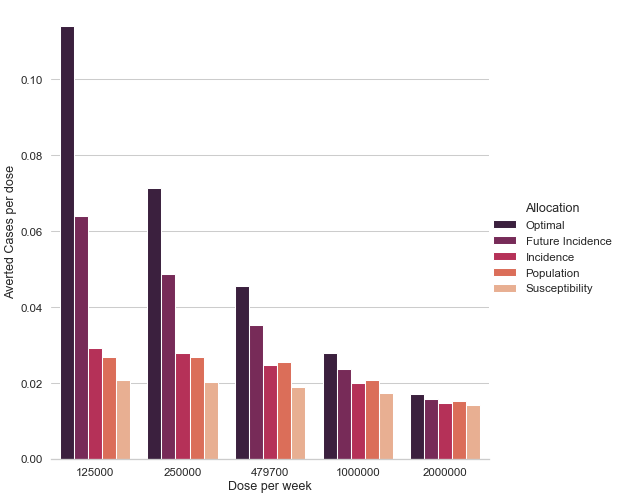

In [6]:
#fig, ax = plt.subplots(figsize=(10,10))
sns.set(rc={'figure.figsize':(10,5), 'figure.dpi':50})
sns.set_theme(style="whitegrid")
sns.set_context("talk")

g = sns.catplot(
    data=scn_results[(scn_results['scenario-rate']=='r15') & (scn_results['scenario-beta']=='L')],
    kind="bar",
    x="newdoseperweek",
    y="avertedpervacc", 
    #y="averted",
    hue="method",
    palette="rocket",
    #alpha=.9, 
    height=10,
)
g.despine(left=True)
#g.fig.suptitle(f'Simulation on {setup.ndays} days, rate of 7.5M per month')
g.set_axis_labels("Dose per week", "Averted Cases per dose")
g.legend.set_title("Allocation")
#g.set_xticklabels([str(i/1e6)+'M' for i in np.sort(scn_results['total_vacc'].unique())])

g.fig.savefig('figures/scenarios.pdf') 

In [ ]:
g = sns.lineplot(
    data=scn_results, 
    x="newdoseperweek", y="averted", hue="method",
    palette="rocket", marker = 'o', 
    #alpha=.9, 
)

In [ ]:
scn_results_ts = {}
methods = ['opi', 'inc', 'pop', 'sus', 'cas'] # 'opt'
for met in methods:
    for scenario_name, scenario in scenarios_opt.items():
        maxvaccrate_regional, stockpile_national, stockpile_national_constraint, control_initial = build_scenario(setup, scenario)
        dosesperweek = int(scenario_name.split('-')[2][1:])
        ratepermonth = int(scenario_name.split('-')[1][1:])*1e6
        md = pd.read_csv(f'model_output/scenarios/{scenario_name}-{met}-{nnodes}_{ndays}.csv', index_col= 'date', parse_dates=True)
        scn_results_ts[met+'-'+scenario_name] = md[md.index < str(setup_ocp.end_date)]

In [ ]:
sp

In [ ]:
sp.index(name.split('-'))

In [ ]:
fig, axes = plt.subplots(2,2, figsize = (20,10), dpi=200)
fig.patch.set_facecolor('white')

nd = 0

sp = []

for name, ts in scn_results_ts.items():
    if name.split('-')[-2] not in sp:
        sp.append(name.split('-')[-2])
    ax = axes.flat[sp.index(name.split('-')[-2])]
    
    ax.plot(ts[ts['comp']=='vacc'].pivot(columns = 'place', values='value').cumsum().sum(axis=1), linestyle='-.', lw = 2, label=name.split('-')[0], alpha = .9)
    ax.set_title(name.split('-')[-2]);
    ax.legend()